# Proyecto Inteligencia Artificial
Stefano Aragoni, Luis Diego Santos, Carol Arevalo

______________________

El objetivo del presente proyecto es detectar los tweets que puedan estar relacionados con cyberbulling. Para ello se descargo una base de datos de tweets del 2020. 

---------------
### Exploración y Limpieza de Datos
Como primer paso, se importa el archivo a través de distintas librerías. 

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from tqdm import tqdm
import re

from sklearn import datasets
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.svm import SVC

from nltk.stem import SnowballStemmer

from pandas.plotting import scatter_matrix
import pandas_profiling

from prettytable import PrettyTable

import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords

/var/folders/wq/gs7vpwkj7k31lw9njy09srjw0000gn/T/ipykernel_5248/995464139.py:24: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  import pandas_profiling
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/stefanoaragoni/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/stefanoaragoni/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
#cargar dataset
data = pd.read_csv('cyberbullying_tweets.csv')

In [4]:
# Imprimir las primeras 5 filas
data.head()

,tweet_text,cyberbullying_type
0,"In other words #katandandre, your food was cra...",not_cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying


In [5]:
# Imprimir las últimas 5 filas
data.tail()

,tweet_text,cyberbullying_type
78850,@user #chroniclescontinues that moment when @...,not_cyberbullying
78851,#divers from all over the world ....we had a b...,not_cyberbullying
78852,we are all shocked to hear the news about @use...,not_cyberbullying
78853,ð em so excited en i just can't hide it ð...,not_cyberbullying
78854,turn a ho-hum #exterior into your place with...,not_cyberbullying


##### Datos Faltantes
En este caso, primero se analizó si hacían falta datos en el dataset. En este caso, todos los datos estaban almacenados y no habían datos fuera de lugar.

Index([], dtype='object')

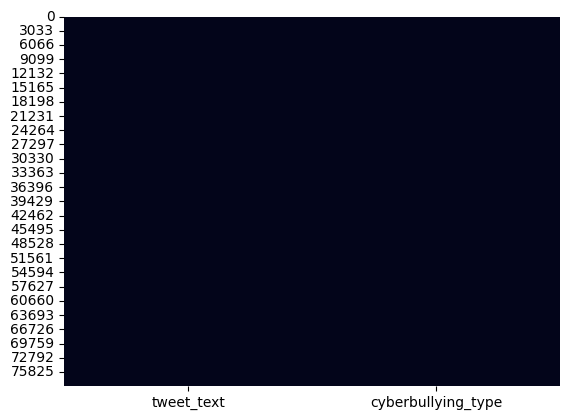

In [6]:
# Matriz de datos faltantes
sns.heatmap(data.isnull(), cbar=False)

# Mostrar columnas con datos faltantes, o con datos fuera de lugar (como un string en columna numérica)
data.columns[data.isnull().any()]

##### Datos Duplicados
Se buscaron datos dupllicados para eliminarlos y tener un modelo más exacto.


In [7]:
data['tweet_text'] = data['tweet_text'].str.lower()

#verificar datos duplicados
data.duplicated().sum()

2018

In [8]:
#eliminar datos duplicados
data.drop_duplicates(inplace=True)
data.duplicated().sum()

0

##### Distribución de clases
Este tipo de análisis es útil para obtener una mejor comprensión de la distribución de los diferentes tipos de ciberacoso en los datos y para identificar los tipos de ciberacoso más comunes en un conjunto de datos.

In [9]:
# Contar la frecuencia de cada valor único en la columna "cyberbullying_type"
frecuencias = data['cyberbullying_type'].value_counts()

# Mostrar los resultados
print(frecuencias)

not_cyberbullying      37141
religion                7994
age                     7979
ethnicity               7953
gender                  7947
other_cyberbullying     7823
Name: cyberbullying_type, dtype: int64


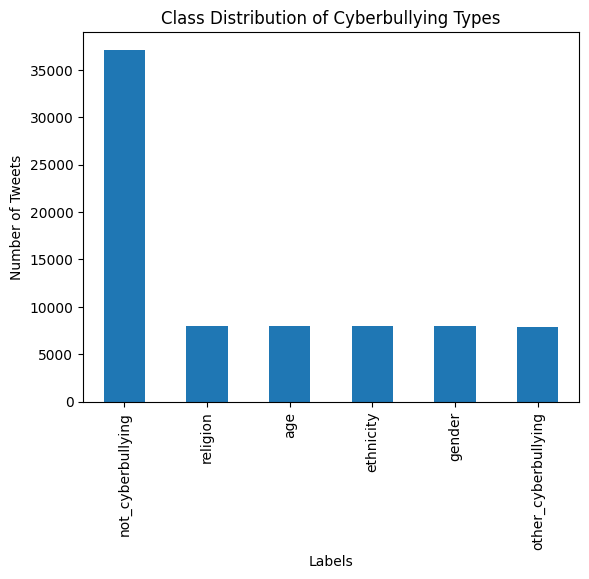

In [10]:
# Create a bar plot of the class distribution
class_counts = data['cyberbullying_type'].value_counts()
class_counts.plot(kind='bar')
plt.title('Class Distribution of Cyberbullying Types')
plt.xlabel('Labels')
plt.ylabel('Number of Tweets')
plt.show()

En este caso, las clases están balanceadas. Entre todas los tipos de ciber acoso, se tiene aproximadamente 38,000 entradas. De no ciber acoso se tiene un valor similar.

### Conteo de palabras 
A continuacion se hace un analisis de las palabras mas comunes de la base de datos. 

In [11]:
# Remover URLs, menciones y hashtags
new_tweets = []
new_types = []

def remove_urls_mentions_hashtags(text, type):
    text = re.sub(r'http\S+', '', text) # URLs
    text = re.sub(r'@\S+', '', text) # Menciones
    text = re.sub(r'#\S+', '', text) # Hashtags

    text = re.sub('<.*?>', '', text) # HTML tags
    text = re.sub('[^a-zA-Z]', ' ', text) # Puntuación y números

    stop_words = set(stopwords.words('english'))
    text = ' '.join([word for word in text.split() if word not in stop_words])

    return text, type

for i in tqdm(range(len(data))):
    try:
        text, type = remove_urls_mentions_hashtags(data['tweet_text'][i], data['cyberbullying_type'][i])
        new_tweets.append(text)
        new_types.append(type)
    except:
        pass

data = pd.DataFrame({
    'tweet_text': new_tweets,
    'cyberbullying_type': new_types
})

100%|██████████| 76837/76837 [00:17<00:00, 4437.70it/s]


In [12]:
# Frecuencia de cada palabra
tweets = ' '.join(data['tweet_text'].values)
words = tweets.split()

frecuencia = Counter(words).most_common(10)

frecuencia

[('school', 8991),
 ('like', 6895),
 ('fuck', 5938),
 ('rt', 5660),
 ('people', 5613),
 ('dumb', 5389),
 ('high', 5314),
 ('u', 4923),
 ('bullied', 4691),
 ('nigger', 4444)]

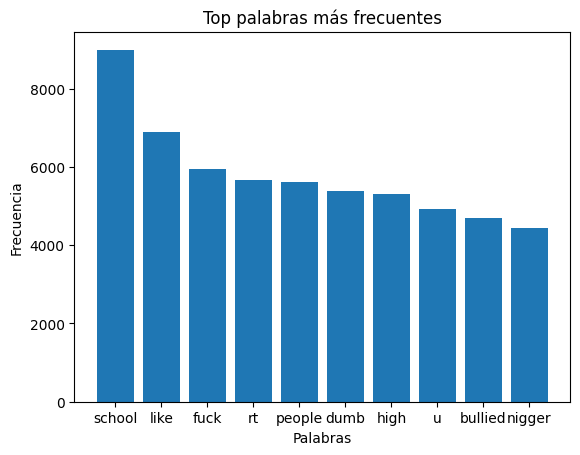

In [13]:
# diagrama de barras
plt.bar(*zip(*frecuencia))
plt.title('Top palabras más frecuentes')
plt.xlabel('Palabras')
plt.ylabel('Frecuencia')
plt.show()

-----------
## Creación de Modelos

En este caso, como primer punto se separó el dataset en tres partes: una para entrenamiento, otra para validación y otra para prueba.

Con esto en mente, se busca poder generar diferentes modelos para poder compararlos y ver cual es el que mejor se ajusta a los datos. Primero se utilizó el set de validación para, a través de GridSearchCV encontrar los mejores parametros. Posteriormente, en creación de modelos se utilizó 80% de los datos para la generación de los mismos. 


In [14]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(data['tweet_text']).toarray()

y = data['cyberbullying_type']

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=7)

best_models = []

### Regresion Logistica

In [16]:
param_grid = {
    'C': [0.1, 1],
    'max_iter': [1000],
}

lr = LogisticRegression()
clf = GridSearchCV(lr, param_grid, cv=5)
clf.fit(X_val, y_val)

best_lr = LogisticRegression(**clf.best_params_)
best_lr.fit(X_train, y_train)

accuracy = accuracy_score(y_test, best_lr.predict(X_test))
best_models.append(('Logistic Regression', clf.best_params_, accuracy))

print("Regresion Logistica: ", accuracy, "\n")

In [ ]:
# Matrix and classification report
print(confusion_matrix(y_test, best_lr.predict(X_test)))
print("\n\n")
print(classification_report(y_test, best_lr.predict(X_test)))

### Multinomial Naive Bayes

In [ ]:
param_grid = {
    'fit_prior': [True, False]
}

nb = MultinomialNB()
clf = GridSearchCV(nb, param_grid, cv=5)
clf.fit(X_val, y_val)

best_nb = MultinomialNB(**clf.best_params_)
best_nb.fit(X_train, y_train)

accuracy = accuracy_score(y_test, best_nb.predict(X_test))
best_models.append(('Naive Bayes', clf.best_params_, accuracy))

print("Naive Bayes: ", accuracy, "\n")

Naive Bayes:  0.7628887942053686 



In [ ]:
# Matrix and classification report
print(confusion_matrix(y_test, best_nb.predict(X_test)))
print("\n\n")
print(classification_report(y_test, best_nb.predict(X_test)))

[[765   4   2   4   2   1]
 [  7 748   2   0   6  10]
 [ 26  31 640  32  31  16]
 [124  45  49 249 205  86]
 [131  68  69  84 352  44]
 [  5   2  14   9   4 827]]



                     precision    recall  f1-score   support

                age       0.72      0.98      0.83       778
          ethnicity       0.83      0.97      0.90       773
             gender       0.82      0.82      0.82       776
  not_cyberbullying       0.66      0.33      0.44       758
other_cyberbullying       0.59      0.47      0.52       748
           religion       0.84      0.96      0.90       861

           accuracy                           0.76      4694
          macro avg       0.74      0.76      0.74      4694
       weighted avg       0.75      0.76      0.74      4694

